In [1]:
import Models
import ResNet50_Model


from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader


## VinBigData

In [2]:
from Dataset2 import dataset

DATA_DIR = '../vinbigdata-chestXRay/'

boxes_dir = DATA_DIR+'converted_data.csv'
images_dir = DATA_DIR+'converted'

train_dataset, valid_dataset, test_dataset = dataset(7, images_dir, boxes_dir, no_finding=True)

The number of training images: 11836
The number of validation images: 1480
The number of the test images: 1480


In [3]:
# import thr model
import importlib
Models = importlib.reload(Models)
ResNet50_Model = importlib.reload(ResNet50_Model)


In [4]:
# from WholeDataset import dataset_whole
# train_dataset, valid_dataset, test_dataset = dataset_whole(images_dir, boxes_dir, 14)


In [5]:
# initialize the computer device
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initalize the model
model = Models.model(model_type='efficient', pretrained=True, requires_grad=True, res='None', num_classes=7).to(device)
# load the model checkpoint
checkpoint=torch.load('../outputs/best_model_efficient.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
len(testloader.dataset)

1480

In [7]:
for image, label, bbox, idx in testloader:
    print(image.shape)
    print(label)
    print(idx)
    print(bbox)
    break

torch.Size([1, 3, 224, 224])
tensor([[0, 0, 0, 0, 0, 0, 1]])
tensor([28])
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float64)


In [8]:
labels = {0: 'Aortic enlargement',
         1: 'Atelectasis',
         2: 'Calcification',
         3: 'Cardiomegaly',
         4: 'Consolidation',
         5: 'ILD', 
         6: 'Infiltration',
         7: 'Lung opacity',
         8: 'Nodule/Mass',
         9: 'Other lesion',
         10: 'Pleural effusion',
         11: 'Pleural thickening',
         12: 'Pneumothorax',
         13: 'Pulmonary fibrosis',
         14: 'No_finding'}

In [9]:
from sklearn.metrics import precision_score,f1_score
counter=0.
predictions = []
true_labels = []
idxs = []
label_indices=[]
preds = []
test_running_correct_samples = 0.

for image, label, bbox, idx in tqdm(testloader): 
    counter+=1
    image = image.to(device)
    label = label.to(device)
    idx = idx.detach().cpu().numpy().astype('int')
    idxs.append(idx)
    # Forward pass
    output = model(image)
    
    pred = torch.sigmoid(output)[0].detach().cpu().numpy().astype('float')
    
    output = torch.sigmoid(output)>=0.65
    output = output.detach().cpu().numpy()
    #print(output, label)
    label = label.detach().cpu().numpy().astype('int')
    indices = [i for i in range(len(label[0])) if label[0][i]==1]
   
    predictions.append(output[0])
    true_labels.append(label[0])
    label_indices.append(indices)
    preds.append(pred)
    
    test_running_correct_samples += f1_score(label, output, average = 'samples')
   
    
test_acc_sample = test_running_correct_samples/len(testloader.dataset)

print(f"samples/f1: {test_acc_sample:.3f}")


100%|██████████| 1480/1480 [00:44<00:00, 33.51it/s]

samples/f1: 0.860


In [7]:
# Test acuuracy fo 3 classes
# acc_0.5 = 0.876, acc_0.7: 0.806, acc_0.6: 0.847

# test accuracy for 4 classes
# acc = 0.745

# test accuracy for 4classes without no finding
# acc=0.773

# test accuracg for 5 classes with no finding and pos weight
# acc = 0.778
# test accuracy for 5 classes 
# acc = 0.743

# test accuracy for 7 classes
# acc = 0.857   # acc_7_2 = 0.817, acc_7_2_0.65 = 0.797

# test accyracy for 10 classes
# acc = 0.822

# test accuracy for 14 classes without the no finding
# acc = 0.61

# test accuracy for all classes
# acc_0.5 = 0.789, acc_0.8 = 0.770, acc_0.9 = 0.73, acc_0.7 = 0.783

# test accuracy for 7 classes with resnet18
# acc_0.5  = 0.82, acc_0.65=0.812

# test accuracy for 7 classes with resnet101
# acc_0.65 = 0.842, acc_0.5 = 0.85


### Confusion matrix for 3 labels


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3",  "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[1133   81]
 [  25  260]]
Confusion matrix for label 3:
[[1209   62]
 [  28  200]]
Confusion matrix for label 14:
[[1371   75]
 [  13   40]]


In [14]:
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       137
           3       0.85      0.85      0.85       123
          14       0.95      0.94      0.95       121

   micro avg       0.88      0.91      0.90       381
   macro avg       0.89      0.91      0.90       381
weighted avg       0.88      0.91      0.90       381
 samples avg       0.87      0.91      0.88       381



C:\Users\Theodora\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label)

The roc auc score for each class is: [0.93735626 0.93572154 0.98372615]


<function matplotlib.pyplot.show(close=None, block=None)>

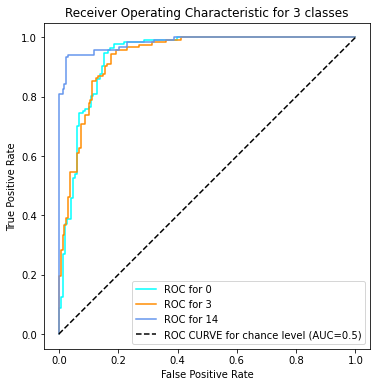

In [16]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]}",
            color=color)


plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 3 classes")
plt.legend()
plt.show

### Confusion matrix for 4 labels


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0",  "3",  "11", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[138  26]
 [ 27 145]]
Confusion matrix for label 3:
[[192  25]
 [ 21  98]]
Confusion matrix for label 11:
[[172  45]
 [ 49  70]]
Confusion matrix for label 14:
[[212   9]
 [ 16  99]]


In [32]:
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       172
           3       0.80      0.82      0.81       119
          11       0.61      0.59      0.60       119
          14       0.92      0.86      0.89       115

   micro avg       0.80      0.78      0.79       525
   macro avg       0.79      0.78      0.79       525
weighted avg       0.80      0.78      0.79       525
 samples avg       0.75      0.78      0.75       525



C:\Users\Theodora\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import roc_curve

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)

The roc auc score for each class is: [0.93264322 0.93877551 0.79789335 0.96993901]


<function matplotlib.pyplot.show(close=None, block=None)>

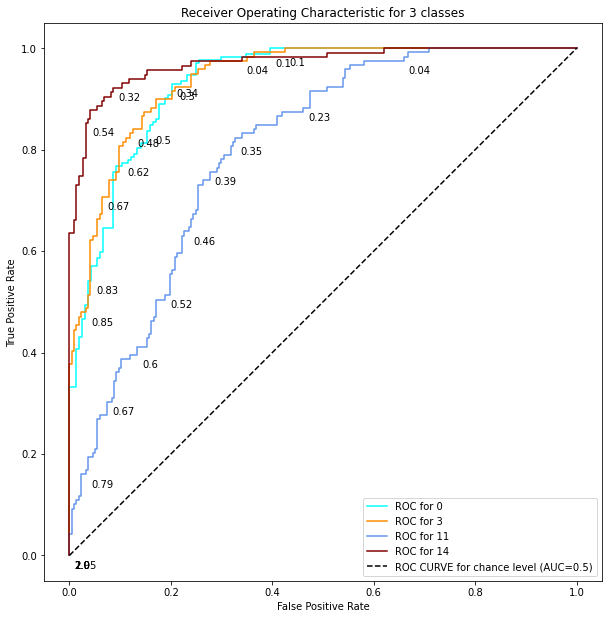

In [34]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

plt.figure(figsize=(10,12))


colors = cycle(["aqua", "darkorange", "cornflowerblue", "maroon"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]}",
            color=color)
#     rnd_idx = 30
#     plt.annotate(np.round(thresholds_dict[labels[label_col]][rnd_idx], 2),
#                 xy = (fpr_dict[labels[label_col]][rnd_idx], tpr_dict[labels[label_col]][rnd_idx]),
#                 xytext = (fpr_dict[labels[label_col]][rnd_idx]+0.025, tpr_dict[labels[label_col]][rnd_idx]-0.025))
    for x, y, txt in zip(fpr_dict[labels[label_col]][::13], tpr_dict[labels[label_col]][::13], thresholds_dict[labels[label_col]][::13]):
        plt.annotate(np.round(txt, 2), (x+0.01, y-0.025))
    
#     rnd_idx = 23
#     plt.annotate('this point refers to the tpr and the fpr \n at a probability threshold of {}'.format(np.round(thresholds_dict[rnd_idx], 2)),
#                 xy = (fpr_dict[labels[label_col]][rnd_idx], tpr_dict[labels[label_col]][rnd_idx]), 
#                  xytext = (fpr_dict[labels[label_col]][rnd_idx]+0.2, tpr_dict[labels[label_col]][rnd_idx]-0.25),
#                  arrowprops = dict(facecolor='black', lw = 2, arrowstyle = '->'),) 
    
    


plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 3 classes")
plt.legend()
plt.show

### Confusion matrix for 4 labels without no finding

In [66]:
from sklearn.metrics import confusion_matrix
y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0",  "3", "11", "13"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[157  35]
 [ 31 155]]
Confusion matrix for label 3:
[[213  22]
 [ 32 111]]
Confusion matrix for label 11:
[[211  50]
 [ 47  70]]
Confusion matrix for label 13:
[[236  22]
 [ 48  72]]


## Confusion matrix for 5 labels

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0",  "3", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[172  20]
 [ 45 141]]
Confusion matrix for label 3:
[[207  28]
 [ 25 118]]
Confusion matrix for label 11:
[[211  50]
 [ 48  69]]
Confusion matrix for label 13:
[[230  28]
 [ 48  72]]
Confusion matrix for label 14:
[[244  18]
 [  5 111]]


In [12]:
print(classification_report(y_true, y_pred, target_names = labels))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81       186
           3       0.81      0.83      0.82       143
          11       0.58      0.59      0.58       117
          13       0.72      0.60      0.65       120
          14       0.86      0.96      0.91       116

   micro avg       0.78      0.75      0.76       682
   macro avg       0.77      0.75      0.75       682
weighted avg       0.78      0.75      0.76       682
 samples avg       0.76      0.78      0.75       682



C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)

The roc auc score for each class is: [0.92551523 0.95488767 0.82811016 0.84744832 0.98868123]


<function matplotlib.pyplot.show(close=None, block=None)>

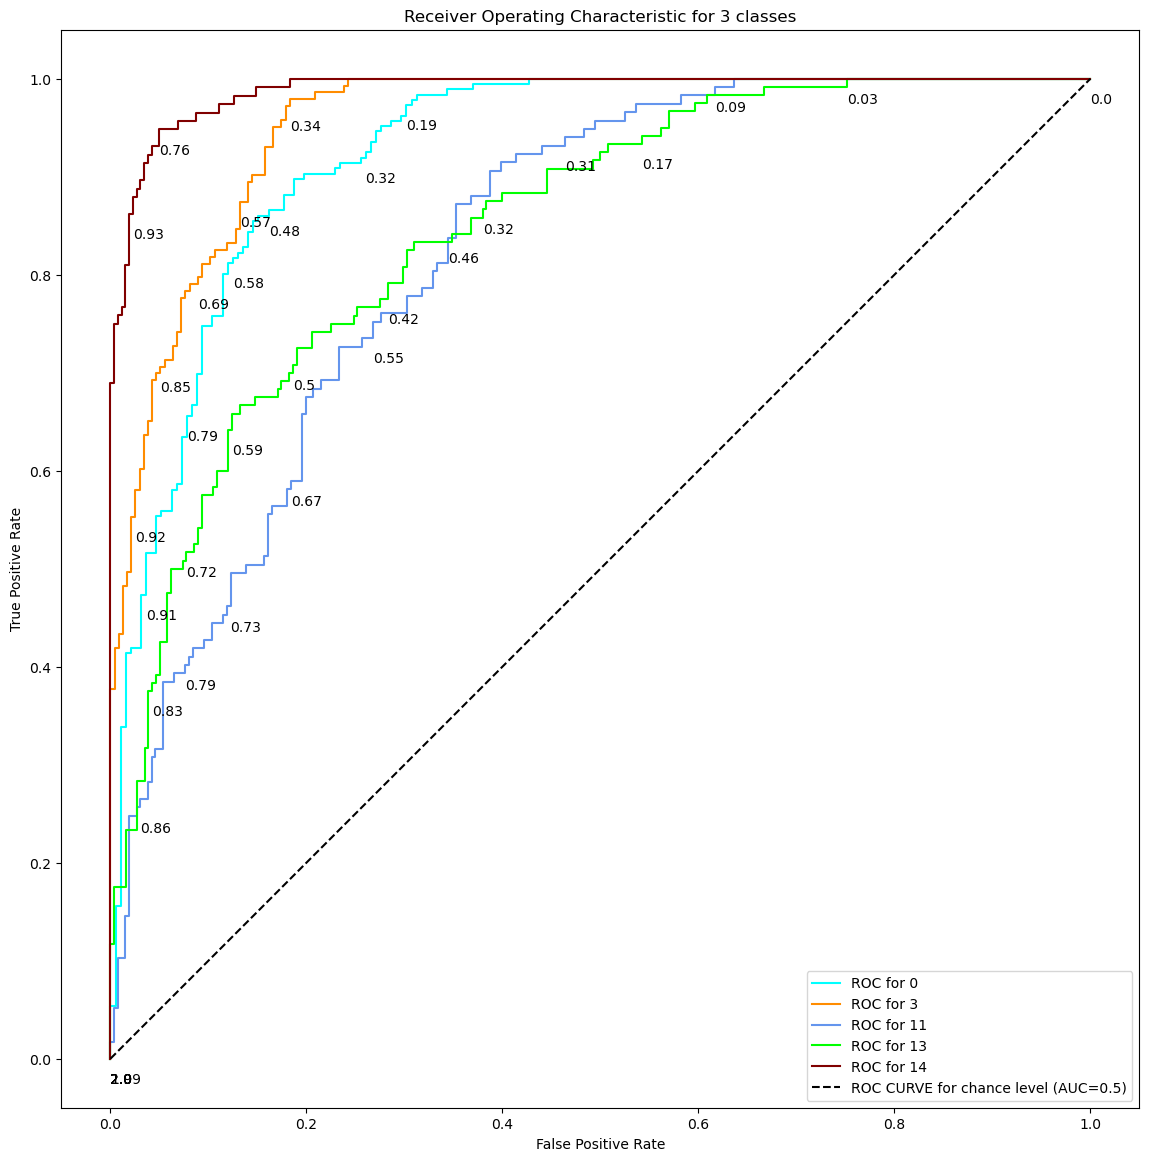

In [14]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

plt.figure(figsize=(16,14))


colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime", "maroon"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]}",
            color=color)
    for x, y, txt in zip(fpr_dict[labels[label_col]][::13], tpr_dict[labels[label_col]][::13], thresholds_dict[labels[label_col]][::13]):
        plt.annotate(np.round(txt, 2), (x, y-0.025))

plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 3 classes")
plt.legend()
plt.show

## Confusion matrix for 7 labels - Efficient

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "7", "10", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]]=confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)



Confusion matrix for label 0:
[[1106   63]
 [  35  276]]
Confusion matrix for label 3:
[[1191   58]
 [  31  200]]
Confusion matrix for label 7:
[[1204  129]
 [  36  111]]
Confusion matrix for label 10:
[[1281   87]
 [  16   96]]
Confusion matrix for label 11:
[[1093  175]
 [  33  179]]
Confusion matrix for label 13:
[[1179  141]
 [  36  124]]
Confusion matrix for label 14:
[[419  11]
 [ 69 981]]


In [11]:
class_predicted = {0:'Aortic enlargement',
                  1: 'Cardiomegaly',
                  2: 'Lung Opacity',
                  3: 'Pleural effusion',
                  4: 'Pleural thickening',
                  5: 'Pulmonary fibrosis',
                  6: 'No finding'
                  }

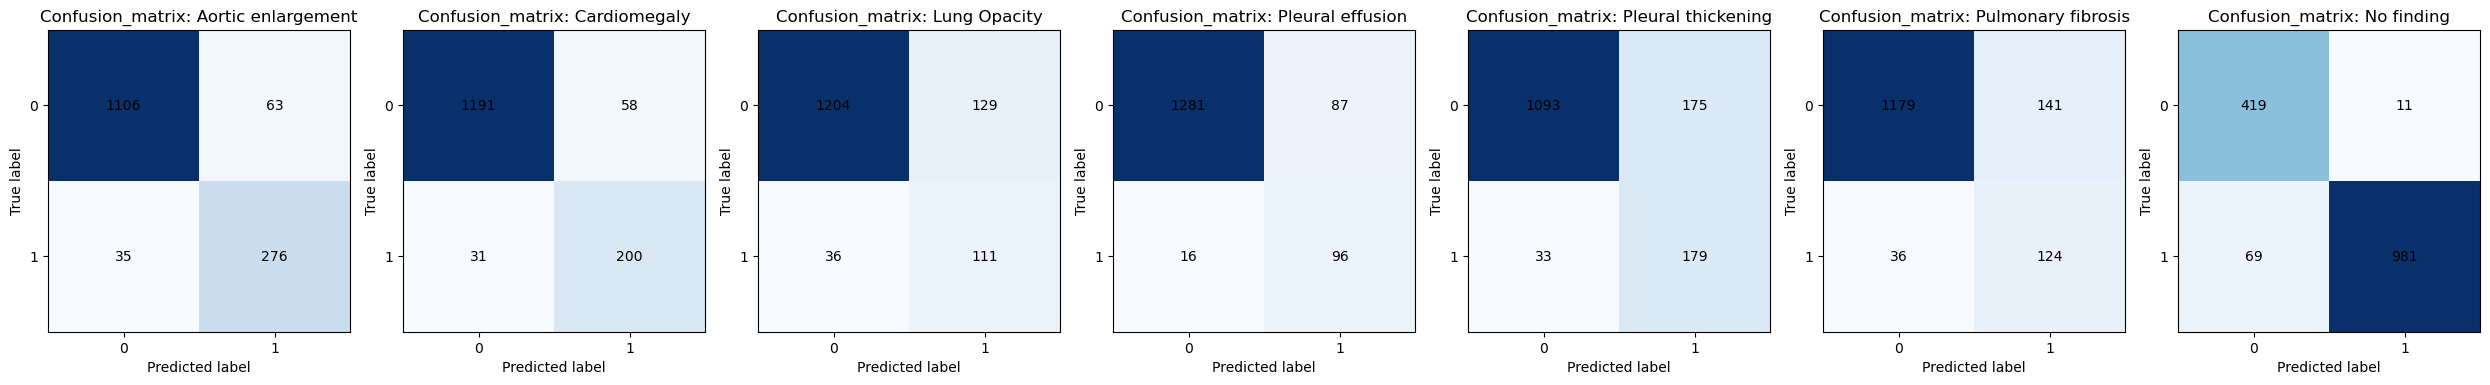

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
#y_pred_binary = (y_pred > 0.5).astype(int)

y_pred_b = (y_pred > 0.65).astype(int) 
cm = multilabel_confusion_matrix(y_true, y_pred_b)

# Plot confusion matrix for each label
fig, axes = plt.subplots(nrows = 1, ncols=7, figsize=(25,5))
for c in range(len(cm)):
    conf_matrix = cm[c]
    names = ['Negative', 'Positive'] 
    ax = axes[c]
    
    # Plot the confusion matrix as image
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap = plt.cm.Blues)
    
    # Plot the number in each cell
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j,i, str(conf_matrix[i,j]), ha='center', va='center', color='black')
            
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
          yticks = np.arange(conf_matrix.shape[0]),
          title=f'Confusion_matrix: {class_predicted[c]}',
          ylabel = 'True label',
          xlabel = 'Predicted label')


plt.tight_layout()

# Save the figure 
plt.savefig('../outputs/Confusion_matrix_7c.png')
plt.show()

In [13]:
print(classification_report(y_true, y_pred, target_names = labels, zero_division=1))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       311
           3       0.78      0.87      0.82       231
           7       0.46      0.76      0.57       147
          10       0.52      0.86      0.65       112
          11       0.51      0.84      0.63       212
          13       0.47      0.78      0.58       160
          14       0.99      0.93      0.96      1050

   micro avg       0.75      0.88      0.81      2223
   macro avg       0.65      0.85      0.72      2223
weighted avg       0.80      0.88      0.83      2223
 samples avg       0.87      0.90      0.86      2223



In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)

The roc auc score for each class is: [0.98079541 0.98425407 0.9402912  0.97050569 0.93324802 0.93183712
 0.99064895]


<function matplotlib.pyplot.show(close=None, block=None)>

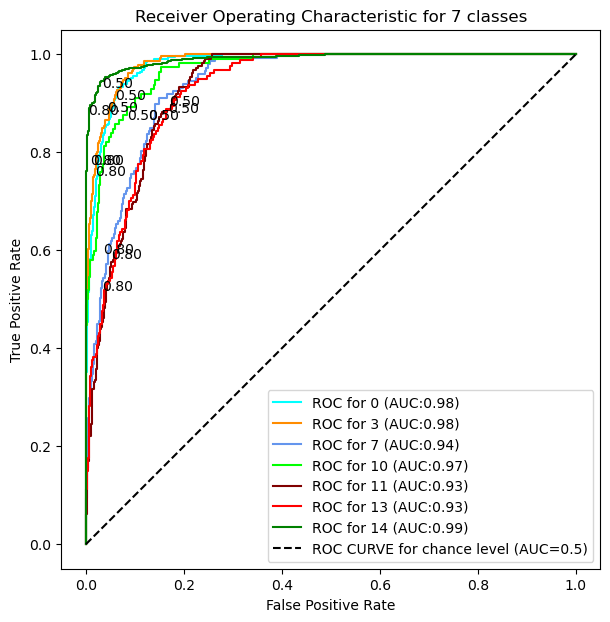

In [15]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

# Define the thresholds
thrs = [0.5, 0.8]

plt.figure(figsize=(10,7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime", "maroon", "red", "green"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]} (AUC:{auc[label_col]:.2f})",
            color=color)
    # Annotate desired thresholds
    for threshold in thrs:
        closest_idx = np.argmin(np.abs(thresholds_dict[labels[label_col]] - threshold))
        x = fpr_dict[labels[label_col]][closest_idx]
        y = tpr_dict[labels[label_col]][closest_idx]
        plt.annotate(f'{threshold:.2f}', (x-0.015, y - 0.025))
            
plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 7 classes")
plt.legend()
plt.show

## Confusion matrix for 7 labels


In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "7", "10", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]]=confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)



Confusion matrix for label 0:
[[1130   39]
 [  49  262]]
Confusion matrix for label 3:
[[1186   63]
 [  21  210]]
Confusion matrix for label 7:
[[1158  175]
 [  25  122]]
Confusion matrix for label 10:
[[1290   78]
 [  12  100]]
Confusion matrix for label 11:
[[1147  121]
 [  52  160]]
Confusion matrix for label 13:
[[1175  145]
 [  38  122]]
Confusion matrix for label 14:
[[414  16]
 [ 69 981]]


In [49]:
class_predicted = {0:'Aortic enlargement',
                  1: 'Cardiomegaly',
                  2: 'Lung Opacity',
                  3: 'Pleural effusion',
                  4: 'Pleural thickening',
                  5: 'Pulmonary fibrosis',
                  6: 'No finding'
                  }

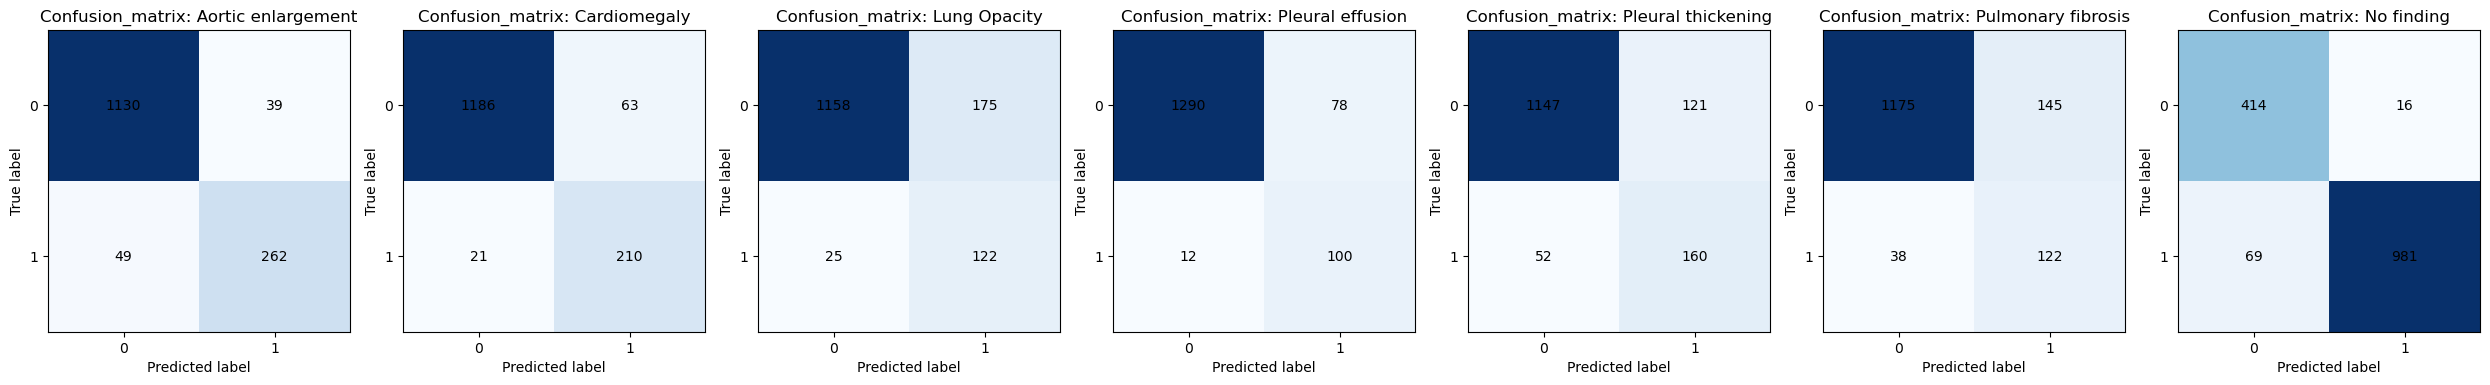

In [46]:
from sklearn.metrics import multilabel_confusion_matrix
#y_pred_binary = (y_pred > 0.5).astype(int)

y_pred_b = (y_pred > 0.65).astype(int) 
cm = multilabel_confusion_matrix(y_true, y_pred_b)

# Plot confusion matrix for each label
fig, axes = plt.subplots(nrows = 1, ncols=7, figsize=(25,5))
for c in range(len(cm)):
    conf_matrix = cm[c]
    names = ['Negative', 'Positive'] 
    ax = axes[c]
    
    # Plot the confusion matrix as image
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap = plt.cm.Blues)
    
    # Plot the number in each cell
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j,i, str(conf_matrix[i,j]), ha='center', va='center', color='black')
            
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
          yticks = np.arange(conf_matrix.shape[0]),
          title=f'Confusion_matrix: {class_predicted[c]}',
          ylabel = 'True label',
          xlabel = 'Predicted label')


plt.tight_layout()

# Save the figure 
plt.savefig('../outputs/Confusion_matrix_7c.png')
plt.show()

In [53]:
print(classification_report(y_true, y_pred, target_names = labels, zero_division=1))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       311
           3       0.77      0.91      0.83       231
           7       0.41      0.83      0.55       147
          10       0.56      0.89      0.69       112
          11       0.57      0.75      0.65       212
          13       0.46      0.76      0.57       160
          14       0.98      0.93      0.96      1050

   micro avg       0.75      0.88      0.81      2223
   macro avg       0.66      0.85      0.73      2223
weighted avg       0.81      0.88      0.83      2223
 samples avg       0.87      0.90      0.86      2223



In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)

The roc auc score for each class is: [0.98330945 0.98202891 0.93897964 0.97422593 0.93942697 0.93066288
 0.99055371]


<function matplotlib.pyplot.show(close=None, block=None)>

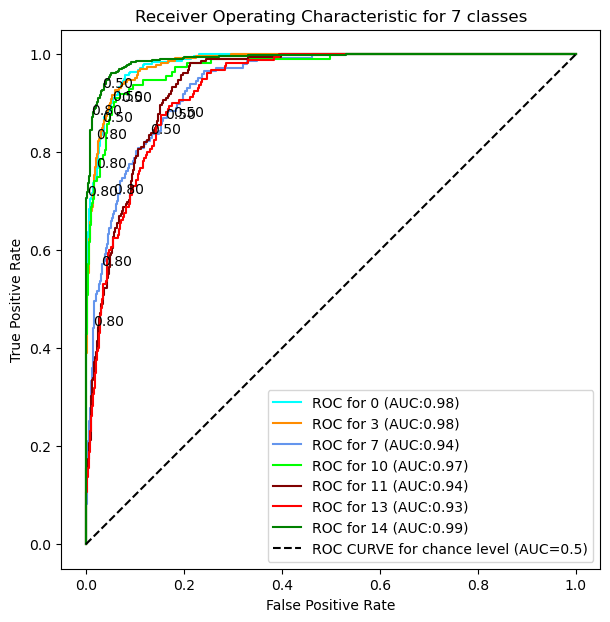

In [59]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

# Define the thresholds
thrs = [0.5, 0.8]

plt.figure(figsize=(10,7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime", "maroon", "red", "green"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]} (AUC:{auc[label_col]:.2f})",
            color=color)
    # Annotate desired thresholds
    for threshold in thrs:
        closest_idx = np.argmin(np.abs(thresholds_dict[labels[label_col]] - threshold))
        x = fpr_dict[labels[label_col]][closest_idx]
        y = tpr_dict[labels[label_col]][closest_idx]
        plt.annotate(f'{threshold:.2f}', (x-0.015, y - 0.025))
            
plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 7 classes")
plt.legend()
plt.show

## Confusion matrix for 7 labels with resnet50_2

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "7", "10", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]]=confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)



Confusion matrix for label 0:
[[1057  112]
 [  34  277]]
Confusion matrix for label 3:
[[1120  129]
 [  23  208]]
Confusion matrix for label 7:
[[1171  162]
 [  33  114]]
Confusion matrix for label 10:
[[1261  107]
 [  34   78]]
Confusion matrix for label 11:
[[1097  171]
 [  44  168]]
Confusion matrix for label 13:
[[1168  152]
 [  40  120]]
Confusion matrix for label 14:
[[407  23]
 [101 949]]


In [16]:
print(classification_report(y_true, y_pred, target_names = labels, zero_division=1))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       311
           3       0.62      0.90      0.73       231
           7       0.41      0.78      0.54       147
          10       0.42      0.70      0.53       112
          11       0.50      0.79      0.61       212
          13       0.44      0.75      0.56       160
          14       0.98      0.90      0.94      1050

   micro avg       0.69      0.86      0.77      2223
   macro avg       0.58      0.82      0.67      2223
weighted avg       0.75      0.86      0.79      2223
 samples avg       0.85      0.87      0.82      2223



In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)

The roc auc score for each class is: [0.961214   0.96321906 0.92501697 0.93178911 0.92128073 0.90493371
 0.97918494]


<function matplotlib.pyplot.show(close=None, block=None)>

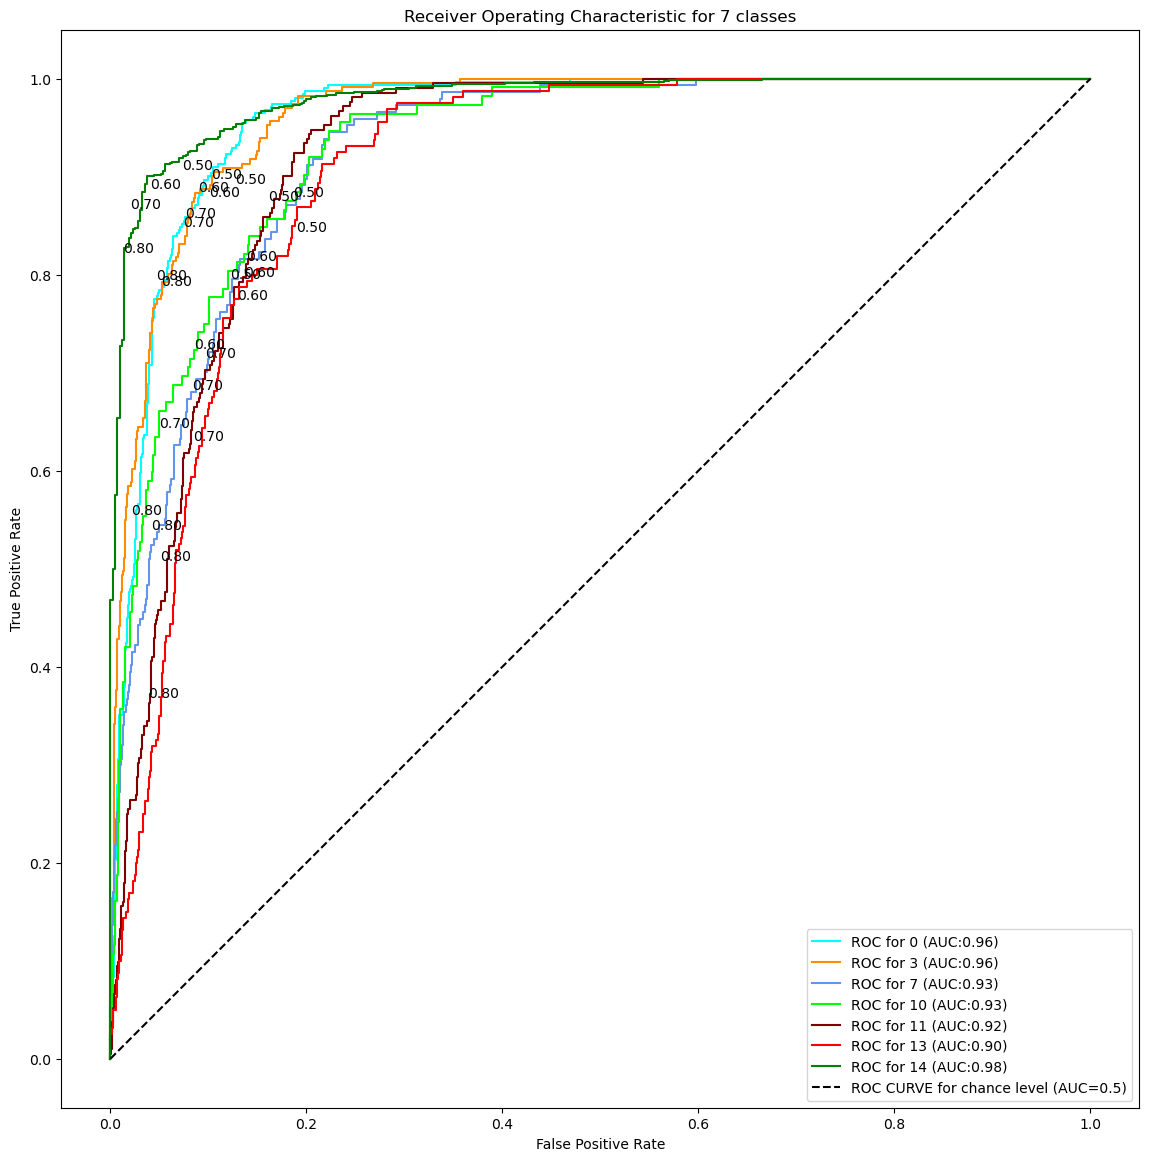

In [29]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

# Define the thresholds
thrs = [0.5, 0.6, 0.7, 0.8]

plt.figure(figsize=(16,14))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime", "maroon", "red", "green"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]} (AUC:{auc[label_col]:.2f})",
            color=color)
    # Annotate desired thresholds
    for threshold in thrs:
        closest_idx = np.argmin(np.abs(thresholds_dict[labels[label_col]] - threshold))
        x = fpr_dict[labels[label_col]][closest_idx]
        y = tpr_dict[labels[label_col]][closest_idx]
        plt.annotate(f'{threshold:.2f}', (x-0.015, y - 0.025))
            
plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 7 classes")
plt.legend()
plt.show

## Confusion matrix for 7 labels with resnet18



In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "7", "10", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]]=confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[1041  128]
 [  14  297]]
Confusion matrix for label 3:
[[1116  133]
 [  12  219]]
Confusion matrix for label 7:
[[1039  294]
 [   7  140]]
Confusion matrix for label 10:
[[1153  215]
 [  13   99]]
Confusion matrix for label 11:
[[1011  257]
 [  13  199]]
Confusion matrix for label 13:
[[981 339]
 [ 10 150]]
Confusion matrix for label 14:
[[420  10]
 [ 91 959]]


In [10]:
print(classification_report(y_true, y_pred, target_names = labels))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       311
           3       0.62      0.95      0.75       231
           7       0.32      0.95      0.48       147
          10       0.32      0.88      0.46       112
          11       0.44      0.94      0.60       212
          13       0.31      0.94      0.46       160
          14       0.99      0.91      0.95      1050

   micro avg       0.60      0.93      0.73      2223
   macro avg       0.53      0.93      0.64      2223
weighted avg       0.73      0.93      0.79      2223
 samples avg       0.78      0.92      0.82      2223



C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion matrix for 7 labels with resnet101

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "7", "10", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]]=confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[1041  128]
 [  14  297]]
Confusion matrix for label 3:
[[1119  130]
 [  10  221]]
Confusion matrix for label 7:
[[1088  245]
 [  17  130]]
Confusion matrix for label 10:
[[1222  146]
 [  22   90]]
Confusion matrix for label 11:
[[1060  208]
 [  26  186]]
Confusion matrix for label 13:
[[1098  222]
 [  24  136]]
Confusion matrix for label 14:
[[398  32]
 [ 59 991]]


In [14]:
print(classification_report(y_true, y_pred, target_names = labels))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       311
           3       0.63      0.96      0.76       231
           7       0.35      0.88      0.50       147
          10       0.38      0.80      0.52       112
          11       0.47      0.88      0.61       212
          13       0.38      0.85      0.53       160
          14       0.97      0.94      0.96      1050

   micro avg       0.65      0.92      0.76      2223
   macro avg       0.55      0.90      0.67      2223
weighted avg       0.74      0.92      0.80      2223
 samples avg       0.82      0.93      0.85      2223



C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion matrix for 7 labels DenseNet

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "7", "10", "11", "13", "14"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]]=confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[1057  112]
 [  14  297]]
Confusion matrix for label 3:
[[1153   96]
 [  16  215]]
Confusion matrix for label 7:
[[1217  116]
 [  41  106]]
Confusion matrix for label 10:
[[1324   44]
 [  22   90]]
Confusion matrix for label 11:
[[1129  139]
 [  45  167]]
Confusion matrix for label 13:
[[1185  135]
 [  40  120]]
Confusion matrix for label 14:
[[421   9]
 [ 87 963]]


In [19]:
print(classification_report(y_true, y_pred, target_names = labels))

              precision    recall  f1-score   support

           0       0.73      0.95      0.82       311
           3       0.69      0.93      0.79       231
           7       0.48      0.72      0.57       147
          10       0.67      0.80      0.73       112
          11       0.55      0.79      0.64       212
          13       0.47      0.75      0.58       160
          14       0.99      0.92      0.95      1050

   micro avg       0.75      0.88      0.81      2223
   macro avg       0.65      0.84      0.73      2223
weighted avg       0.79      0.88      0.83      2223
 samples avg       0.85      0.90      0.86      2223



C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)

The roc auc score for each class is: [0.94233948 0.94885259 0.8935193  0.89649253 0.90489405 0.88712595
 0.96881285]


In [ ]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime", "maroon", "red", "green"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
             label=f"ROC for {labels[label_col]} (AUC={auc[label_col]:.2f})",
             color=color)
    for x, y, txt in zip(fpr_dict[labels[label_col]][::13], tpr_dict[labels[label_col]][::13], thresholds_dict[labels[label_col]][::13]):
        if txt in [0.5, 0.6, 0.7, 0.8]:  # Check if the threshold is in the desired percentages
            plt.annotate(f'Threshold={txt:.2f}', (x, y - 0.025))

plt.plot([0, 1], [0, 1], 'k--', label="ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic for 3 classes")
plt.legend()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

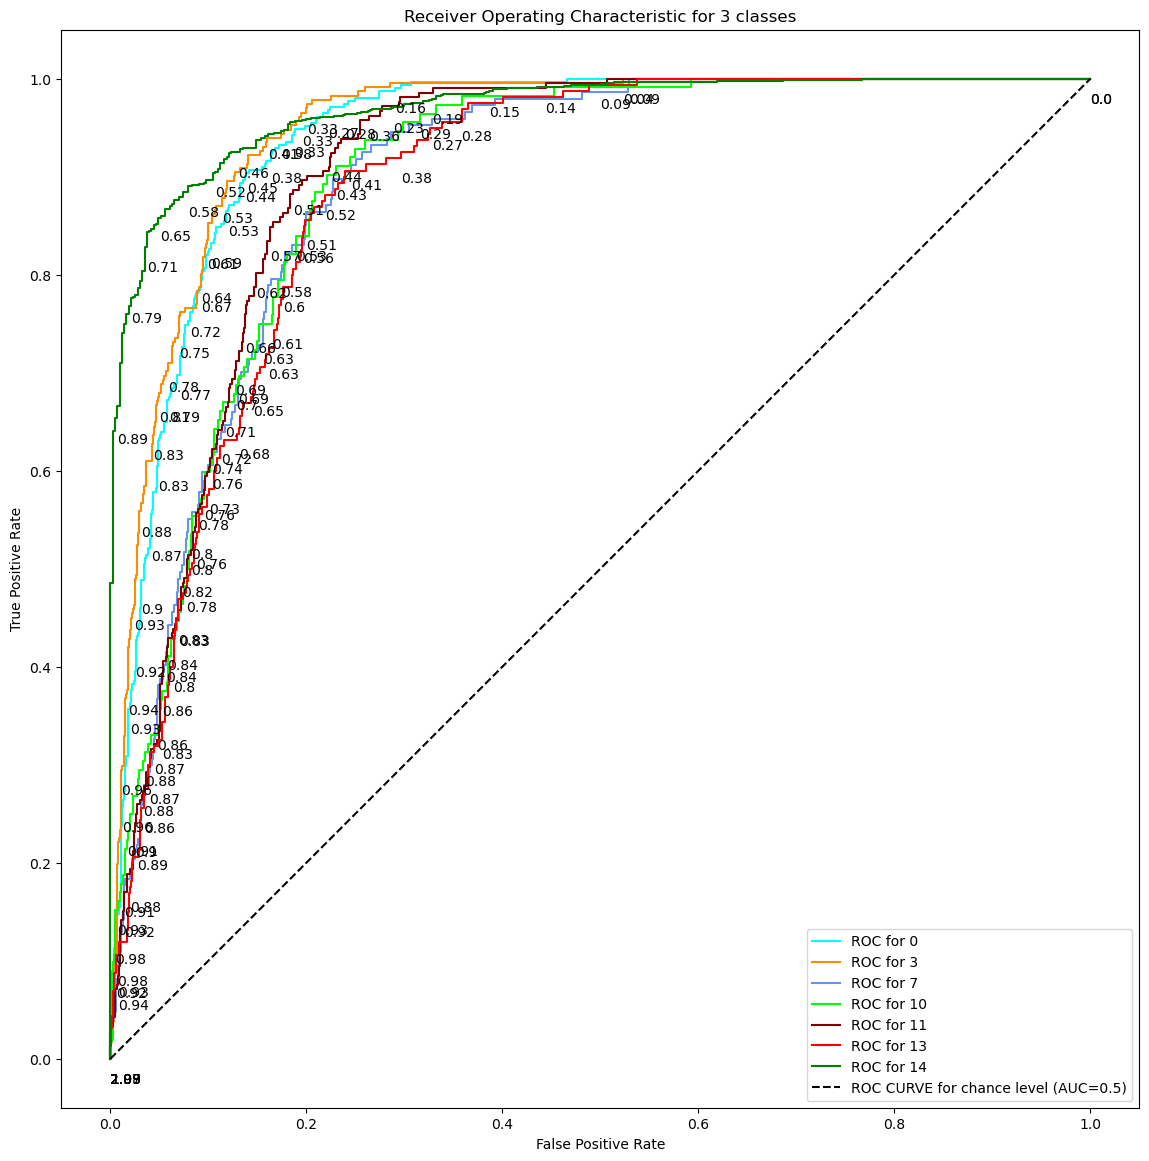

In [29]:
# Plot all ROC curves together
from itertools import cycle
import matplotlib.pyplot as plt

plt.figure(figsize=(16,14))


colors = cycle(["aqua", "darkorange", "cornflowerblue", "lime", "maroon", "red", "green"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]} (AUC:{auc[label_col]:.2f})",
            color=color)
    for x, y, txt in zip(fpr_dict[labels[label_col]][::13], tpr_dict[labels[label_col]][::13], thresholds_dict[labels[label_col]][::13]):
        if txt in [0.5, 0.6, 0.7, 0.8]: # Check if the threshold is in the desired percentages
            plt.annotate(f"Threshold={txt:.2f}", (x, y-0.025))
            
plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 7 classes")
plt.legend()
plt.show

## Confusion matrix for 10 labels

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "3", "6", "7", "8", "9", "10",  "11", "13", "14"]
conf_mat_dict={}
#f1_score = {}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[1121   93]
 [  22  263]]
Confusion matrix for label 3:
[[1201   70]
 [  25  203]]
Confusion matrix for label 6:
[[1363   83]
 [  13   40]]
Confusion matrix for label 7:
[[1277   91]
 [  39   92]]
Confusion matrix for label 8:
[[1288  139]
 [  22   50]]
Confusion matrix for label 9:
[[1240  157]
 [  34   68]]
Confusion matrix for label 10:
[[1357   42]
 [  22   78]]
Confusion matrix for label 11:
[[1162  121]
 [  66  150]]
Confusion matrix for label 13:
[[1242   99]
 [  48  110]]
Confusion matrix for label 14:
[[415   9]
 [108 967]]


In [9]:
print(classification_report(y_true, y_pred, target_names = labels))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       285
           3       0.74      0.89      0.81       228
           6       0.33      0.75      0.45        53
           7       0.50      0.70      0.59       131
           8       0.26      0.69      0.38        72
           9       0.30      0.67      0.42       102
          10       0.65      0.78      0.71       100
          11       0.55      0.69      0.62       216
          13       0.53      0.70      0.60       158
          14       0.99      0.90      0.94      1075

   micro avg       0.69      0.84      0.76      2420
   macro avg       0.56      0.77      0.63      2420
weighted avg       0.76      0.84      0.79      2420
 samples avg       0.82      0.87      0.83      2420



C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion matrix for all labels

In [49]:
from sklearn.metrics import confusion_matrix
y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10",  "11", "12", "13", "14"]
conf_mat_dict={}
#f1_score = {}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[1068  103]
 [  37  292]]
Confusion matrix for label 1:
[[1306  169]
 [   4   21]]
Confusion matrix for label 2:
[[1097  362]
 [   3   38]]
Confusion matrix for label 3:
[[1167   88]
 [  22  223]]
Confusion matrix for label 4:
[[1334  120]
 [   6   40]]
Confusion matrix for label 5:
[[1254  208]
 [   5   33]]
Confusion matrix for label 6:
[[1237  208]
 [   6   49]]
Confusion matrix for label 7:
[[1087  271]
 [  16  126]]
Confusion matrix for label 8:
[[1065  347]
 [   5   83]]
Confusion matrix for label 9:
[[1045  337]
 [  12  106]]
Confusion matrix for label 10:
[[1212  186]
 [  12   90]]
Confusion matrix for label 11:
[[1056  243]
 [  22  179]]
Confusion matrix for label 12:
[[1378  113]
 [   3    6]]
Confusion matrix for label 13:
[[1061  271]
 [  16  152]]
Confusion matrix for label 14:
[[429  30]
 [ 55 986]]


In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       329
           1       0.11      0.84      0.20        25
           2       0.10      0.93      0.17        41
           3       0.72      0.91      0.80       245
           4       0.25      0.87      0.39        46
           5       0.14      0.87      0.24        38
           6       0.19      0.89      0.31        55
           7       0.32      0.89      0.47       142
           8       0.19      0.94      0.32        88
           9       0.24      0.90      0.38       118
          10       0.33      0.88      0.48       102
          11       0.42      0.89      0.57       201
          12       0.05      0.67      0.09         9
          13       0.36      0.90      0.51       168
          14       0.97      0.95      0.96      1041

   micro avg       0.44      0.92      0.60      2648
   macro avg       0.34      0.88      0.45      2648
weighted avg       0.65   

C:\Users\Theodora\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(true_labels)
y_pred = np.array(preds)

auc = roc_auc_score(y_true, y_pred, average=None)
print(f"The roc auc score for each class is: {auc}")

fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
aucs = {}
for label_col in range(len(labels)):
    y_pred_label = y_pred[:, label_col]
    y_true_label = y_true[:, label_col]
    fpr_dict[labels[label_col]], tpr_dict[labels[label_col]], thresholds_dict[labels[label_col]] = roc_curve(y_true_label, y_pred_label, drop_intermediate=True)
    #aucs[labels[label_col]] = roc_auc_score(y_true_label, y_pred_label, average=None)

The roc auc score for each class is: [0.96683789 0.93773559 0.87998796 0.97637206 0.96028946 0.94504644
 0.94162944 0.92938041 0.90500258 0.88515171 0.95244607 0.92613913
 0.95066696 0.92462552 0.9842681 ]


In [52]:
aucs

{'0': 0.9668378934690689,
 '1': 0.937735593220339,
 '2': 0.8799879636904663,
 '3': 0.976372062769331,
 '4': 0.9602894563722265,
 '5': 0.9450464396284829,
 '6': 0.9416294432211387,
 '7': 0.9293804061482296,
 '8': 0.9050025753283544,
 '9': 0.8851517084058967,
 '10': 0.9524460714185532,
 '11': 0.9261391273042027,
 '12': 0.9506669647514717,
 '13': 0.9246255183755184,
 '14': 0.984268101519613}

<function matplotlib.pyplot.show(close=None, block=None)>

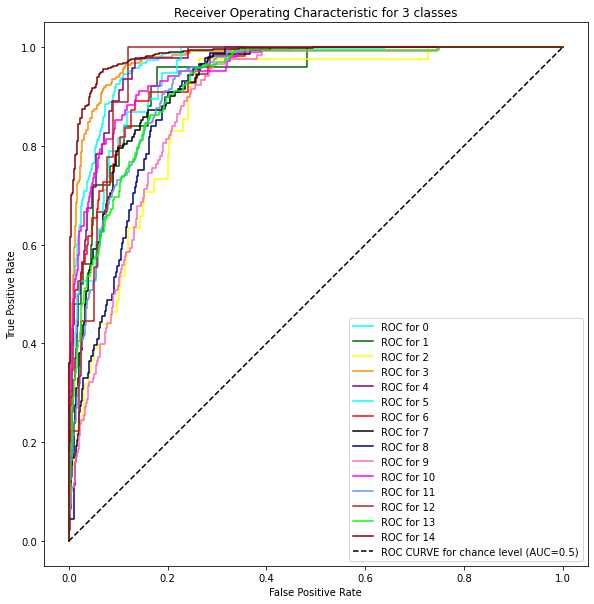

In [54]:
from itertools import cycle
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))


colors = cycle(["aqua", "darkgreen", "yellow", "darkorange", "purple", "aqua", "red", "black", "navy",
                "hotpink", "magenta", "cornflowerblue", "firebrick", "lime", "maroon"])
for label_col, color in zip(range(len(labels)), colors):
    plt.plot(fpr_dict[labels[label_col]], tpr_dict[labels[label_col]],
            label = f"ROC for {labels[label_col]}",
            color=color)
#     for x, y, txt in zip(fpr_dict[labels[label_col]][::30], tpr_dict[labels[label_col]][::30], thresholds_dict[labels[label_col]][::30]):
#         plt.annotate(np.round(txt, 2), (x, y-0.025))

plt.plot([0, 1], [0, 1], 'k--', label = "ROC CURVE for chance level (AUC=0.5)")
plt.axis("square")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("Receiver Operating Characteristic for 3 classes")
plt.legend()
plt.show

## Confusion matrix without no_finding


In [10]:
from sklearn.metrics import confusion_matrix
y_true = np.array(true_labels)
y_pred = np.array(predictions)

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10",  "11", "12", "13"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    #print(y_true_label.shape)
    y_pred_label = y_pred[:, label_col]
    #print(y_pred_label.shape)
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label 0:
[[ 99  23]
 [ 79 239]]
Confusion matrix for label 1:
[[384  31]
 [ 12  13]]
Confusion matrix for label 2:
[[306  94]
 [ 16  24]]
Confusion matrix for label 3:
[[166  41]
 [ 41 192]]
Confusion matrix for label 4:
[[345  51]
 [ 14  30]]
Confusion matrix for label 5:
[[355  47]
 [ 11  27]]
Confusion matrix for label 6:
[[308  79]
 [ 15  38]]
Confusion matrix for label 7:
[[229  74]
 [ 52  85]]
Confusion matrix for label 8:
[[223 133]
 [ 28  56]]
Confusion matrix for label 9:
[[235  91]
 [ 61  53]]
Confusion matrix for label 10:
[[286  55]
 [ 26  73]]
Confusion matrix for label 11:
[[191  60]
 [ 86 103]]
Confusion matrix for label 12:
[[410  21]
 [  3   6]]
Confusion matrix for label 13:
[[199  78]
 [ 58 105]]


## CheXpert

In [7]:
import CheXpertDataset
CheXpertDataset = importlib.reload(CheXpertDataset)

In [5]:
import os
path = os.getcwd()
data_dir = os.path.join(os.path.dirname(path), 'data', 'stanford', 'CheXpert')
data_dir, path

('C:\\Users\\Theodora\\Documents\\master2\\papers for diploma\\Explainability\\MSc_Thesis\\data\\stanford\\CheXpert',
 'C:\\Users\\Theodora\\Documents\\master2\\papers for diploma\\Explainability\\MSc_Thesis\\src')

In [5]:
'''Stanford Dataset'''

image_shape = (224,224)
#idx = [7,10,11,13,15]
classes = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']
policy='diff'
dataset_dir = os.path.join(data_dir, "CheXpert-v1.0-small")
#print(dataset_dir)
batch_size=1
dataset = CheXpertDataset.CheXpert(dataset_dir, classes, policy, image_shape)
train_dataset, valid_dataset, test_dataset = dataset.get_datasets()
trainloader, validloader, testloader = dataset.get_data_loaders(batch_size)

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

counter = 0.
y_pred = []
y_true = []
preds = []

with torch.no_grad():
    for image, label, idx in tqdm(testloader):
        counter = +1
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass
        output = model(image)
        
        pred = torch.sigmoid(output).detach().cpu().numpy().astype('float')
        
        output = torch.sigmoid(output)>=0.5
        output = output.detach().cpu().numpy()
        label = label.detach().cpu().numpy().astype('float')
        
        #print(output, label)
        
        # Flatten output and label
        output = output.flatten()
        label = label.flatten()
        
        #print(output, label)
        
        y_pred.append(output)
        y_true.append(label)
        preds.append(pred)
        
    # Convert list to numpy arrays for f1 score calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate f1 score for each label (each class)
    f1_scores_per_label = f1_score(y_true, y_pred, average=None, zero_division=1)
    
    # Print f1 score for each label (each class)
    for class_idx, f1_score_label in enumerate(f1_scores_per_label):
        print(f"F1 Score for each label {class_idx}: {f1_score_label}")
    
    # Generate a classification report for additional metrics
    report = classification_report(y_true, y_pred, zero_division=1)
    
    # Print the classification report
    print(report)
    
    
#     test_running_correct_samples += f1_score(label, output, average='samples')
        
#     test_acc_sample = test_running_correct_samples/len(testloader.dataset)
#     print(f"samples/f1: {test_acc_sample:.3f}")
        
        

100%|██████████| 284/284 [00:29<00:00,  9.74it/s]

F1 Score for each label 0: 0.4020618556701031
F1 Score for each label 1: 0.6735751295336787
F1 Score for each label 2: 0.0
F1 Score for each label 3: 0.49166666666666664
F1 Score for each label 4: 0.7320754716981133
              precision    recall  f1-score   support

           0       0.97      0.25      0.40       154
           1       0.57      0.82      0.67        79
           2       1.00      0.00      0.00        29
           3       0.72      0.37      0.49       158
           4       0.61      0.92      0.73       105

   micro avg       0.66      0.50      0.56       525
   macro avg       0.77      0.47      0.46       525
weighted avg       0.76      0.50      0.51       525
 samples avg       0.72      0.53      0.54       525



In [ ]:
def img_show(image):
    npimg = image.numpy()
    npimg = np.transpose(npimg, (1,2,0))
    npimg = ((npimg*[0.229, 0.2244, 0.225]) + [0.485, 0.456, 0.406])
    image=np.clip(npimg, 0, 1)
    return npimg

In [86]:
def plot_imgs(imgs, cols=4, size = 7, is_rgb=True, title = ''):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img)
    plt.suptitle(title)
    plt.show()

In [134]:
labels = {0: 'Aortic enlargement',
         1: 'Cardiomagely',
         2: 'Pleural thickening',
         3: 'Pulmonary fibrosis',
         4: 'No finding'}

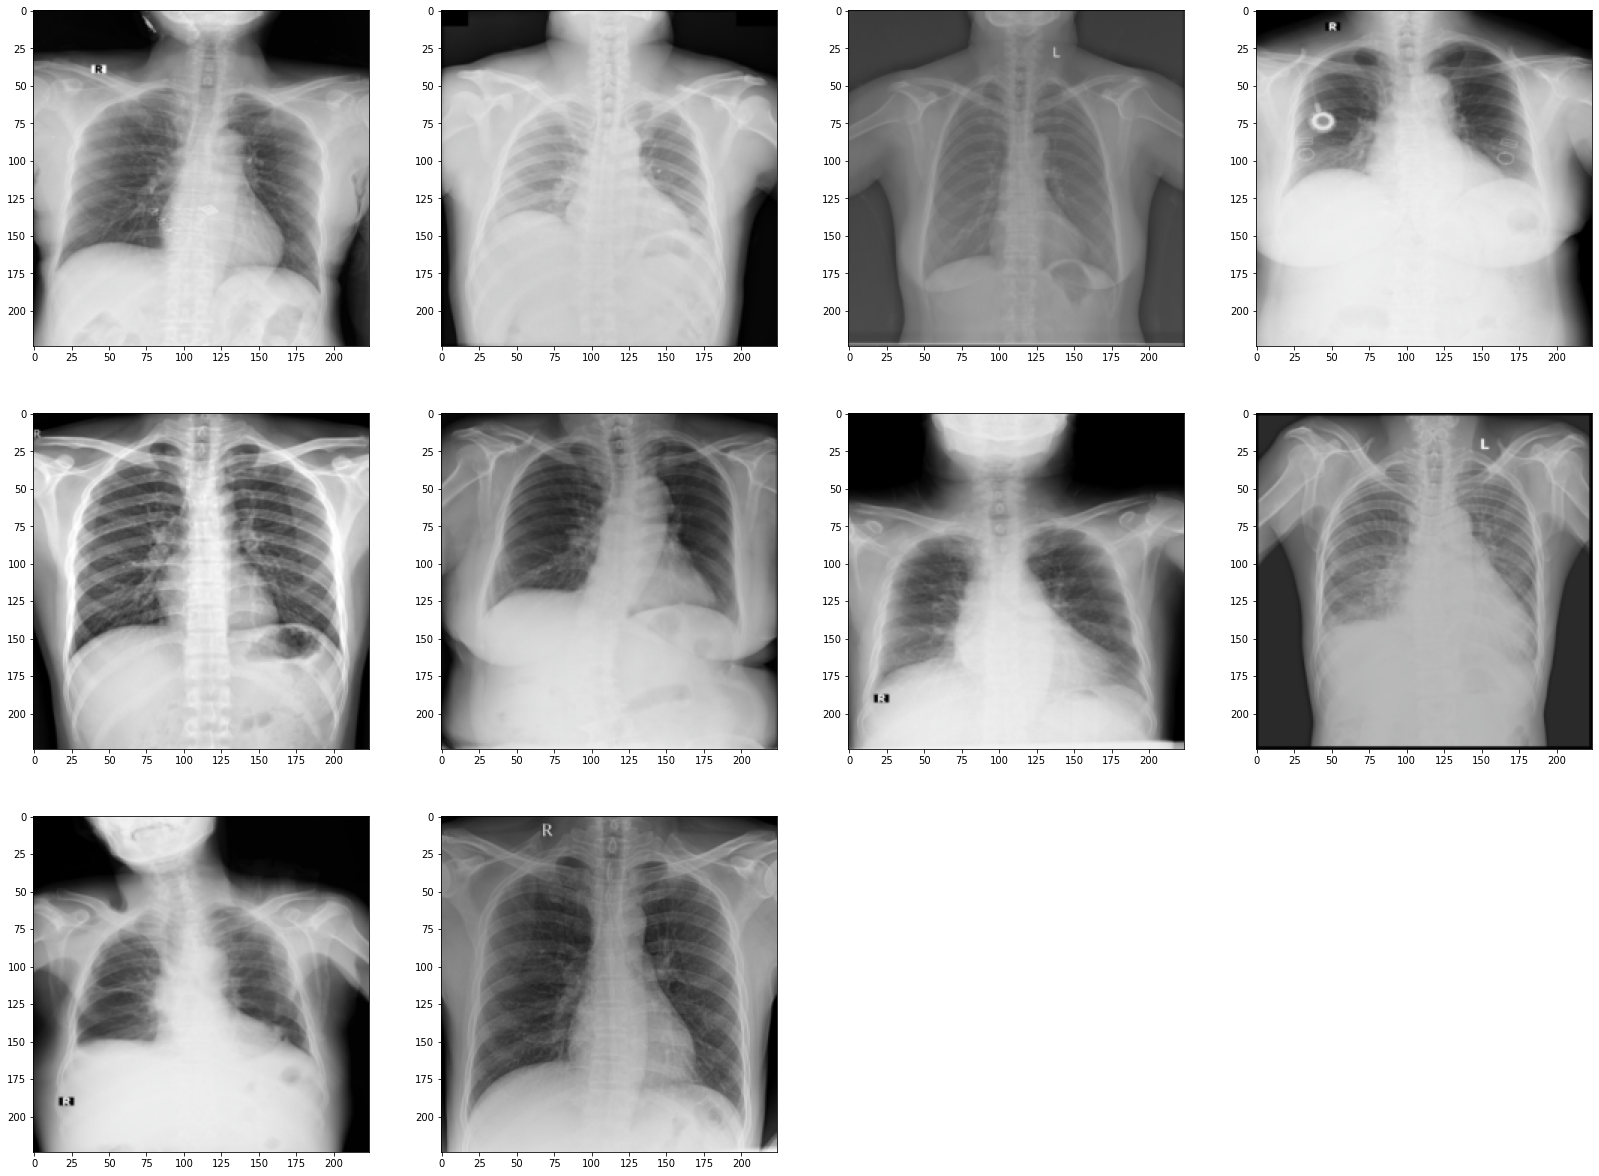

In [189]:
#inv_norm = transforms.Normalize((-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010), (1/0.2023, 1/0.1994, 1/0.2010))

n_imgs = 10
images = []
actual=[]
predicted=[]
it = iter(testloader)

for i in range(0,10):
    image, label, boxes, idx = next(it)
    idx = idx.detach().cpu().numpy().astype('int')
    #print(idx)
    index = idxs.index(idx)
    #print(true_labels[index])
   # print(preds[index])
    img = image[0]
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1,2,0))   
    npimg = ((npimg*[0.229, 0.2244, 0.225]) + [0.485, 0.456, 0.406])
    image=np.clip(npimg, 0, 1)
    images.append(image)
    string_predicted=''
    string_actual = ''
    for i in range(len(preds[index])):
        string_predicted += f'{labels[i]}'
        string_predicted += ', '
    for i in range(len(label_indices[index])):
        string_actual += f'{labels[i]}'
        string_actual += ', '
    predicted.append(string_predicted)
    actual.append(string_actual)
            
plot_imgs(images)

In [190]:
predicted

['Aortic enlargement, ',
 'Aortic enlargement, Cardiomagely, ',
 'Aortic enlargement, ',
 'Aortic enlargement, Cardiomagely, ',
 'Aortic enlargement, ',
 'Aortic enlargement, ',
 'Aortic enlargement, Cardiomagely, ',
 'Aortic enlargement, Cardiomagely, Pleural thickening, Pulmonary fibrosis, ',
 'Aortic enlargement, Cardiomagely, Pleural thickening, ',
 'Aortic enlargement, ']

In [191]:
actual

['Aortic enlargement, ',
 'Aortic enlargement, Cardiomagely, ',
 'Aortic enlargement, ',
 'Aortic enlargement, Cardiomagely, ',
 'Aortic enlargement, ',
 'Aortic enlargement, Cardiomagely, Pleural thickening, ',
 'Aortic enlargement, Cardiomagely, ',
 'Aortic enlargement, Cardiomagely, Pleural thickening, Pulmonary fibrosis, ',
 'Aortic enlargement, Cardiomagely, Pleural thickening, Pulmonary fibrosis, ',
 'Aortic enlargement, ']

In [16]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
layers = model.children()
layers


<generator object Module.children at 0x00000203A149BE60>

In [19]:
features = model.features
features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [21]:
features[-1],        self.first_part_conv = nn.Sequential(*list(features.children())[:layer_index])


Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

In [26]:
import torch.nn as nn
first_part_conv = nn.Sequential(*list(features.children()))
classifier = model.classifier
classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [24]:
first_part_conv[-1]

Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

In [25]:
first_part_conv[-2]

Sequential(
  (0): MBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(1152, 1152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1152, bias=False)
        (1): BatchNorm2d(1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
        (activation): SiLU(inplace=True)
        (scale_activation): Sigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(1152, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):